# Springboard Capstone 3: Preprocessing & Modeling
## RNA Secondary Structure Prediction

Data source: https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding/data<br>
Using the QUICK START file

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# load data
ogdata = pd.read_csv('train_data_QUICK_START.csv')
sequences = ogdata[['sequence_id', 'sequence']].drop_duplicates().reset_index(drop = True)

# define max sequence length (for padding & shape purposes)
maxlength = max([len(x) for x in sequences['sequence']])

# split off test set
train_seqs, test_seqs = train_test_split(sequences, random_state=66)
train_seqs.reset_index(inplace = True)

We will use the `sequence_id` as the unique identifier. Note that initial data set has two lines for each sequence_id corresponding to the two probes (DMS, which modifies bace-pairing surface, and 2A3, which modifies backbone).

The `test_seqs` set split off here will be left until the final step of this notebook, with intermediate steps doing their own further subsetting of the `train_seqs` or other data sets to validate smaller parts of the processing.

In [18]:
def neighbor_finder(base, distance, sequence_series):
    '''Creates a list of the neighbor base identities located the specified distance away
    in the sequence from the argument base. Distance of -1 means immediately preceeding (5'),
    while distance of 1 means immediately following (3').'''
    all_values = []
    for sequence in sequence_series:
        neighbors = (sequence[i + distance] if (i+distance) > 0 else 'None'\
                     for i, ltr in enumerate(sequence) if ltr == base)
        all_values += list(neighbors)
    return all_values

def populate_neighbors(base, distance_list, sequence_series):
    '''Creates a dataframe for a particular base specifying neighbors at positions indicated in
    distance_list using neighbor_finder function.'''
    df = pd.DataFrame()
    for dist in distance_list:
        try:
            df['base_'+str(dist)] = neighbor_finder(base, dist, sequence_series)
        except IndexError:
            df['base_'+str(dist)] = 'None'
    return df

In [19]:
distance_list = [-2, -1, 1, 2]

dfA_neighbors = populate_neighbors('A', distance_list, train_seqs['sequence'])
dfC_neighbors = populate_neighbors('C', distance_list, train_seqs['sequence'])
dfG_neighbors = populate_neighbors('G', distance_list, train_seqs['sequence'])
dfU_neighbors = populate_neighbors('U', distance_list, train_seqs['sequence'])

In [5]:
def findbase(base, sequence):
    '''Generator with all indices where a given base is found in the string RNA sequence'''
    return (i for i, ltr in enumerate(sequence) if ltr == base)

def findbaseDF(base, series):
    '''Iterates the findbase function over a pandas series or equivalent'''
    all_indices = []
    for seq in series:
        idx = findbase(base, seq)
        all_indices += list(idx)
    return all_indices

def vals_from_df(base, dataframe, sequence_series):
    '''Takes dataframe where each row is one RNA sample and each column is some value or readout for a position
    in the sequence and extracts it into one long list that can serve as feature column for other dataframe.'''
    all_values = []
    for i, seq in enumerate(sequence_series):
        idx = findbase(base, seq)
        values = dataframe.iloc[i, idx]
        all_values += list(values)
    return all_values

def populate_properties(base, columns, source_dict):
    '''Uses the above functions to create a dataframe for a particular base containing data for the properties
    outlined as keys of the source_dict from the sources indicated in the dictionary.'''
    df = pd.DataFrame(columns = columns)
    for property in source_dict.keys():
        if property == 'position':
            df[property] = findbaseDF(base, source_dict[property])
        else:
            df[property] = vals_from_df(base, source_dict[property], source_dict['position'])
    return df

In [6]:
# functions for data source prep
def viennaPU(viennaDF, seq_ids):
    '''Get Vienna secondary structure predictions, read out as P (paired) or U (unpaired) from a
    dataframe with an 'ss' column for the sequences in list/series seq_ids.'''
    DF = viennaDF.loc[viennaDF['sequence_id'].isin(seq_ids)]
    
    #tokenize
    ssVienna = DF['ss'].apply(list)
    
    # pad
    ssVienna_padded = ssVienna.apply(lambda x: x + ['N']*(maxlength - len(x)))
    
    ssVienna_pdexp =  pd.DataFrame(np.vstack(ssVienna_padded))
    ssViennaDF = ssVienna_pdexp.replace({'(': 'P', ')': 'P', '.': 'U'})

    return ssViennaDF

def get_reactivity(dataframe, probe, na_val = 0.3):
    df = dataframe[dataframe['experiment_type'] == str(probe)+'_MaP']
    reactivity_cols = [col for col in dataframe.columns if 'reactivity' in col]
    df = df[reactivity_cols].fillna(na_val)
    return df

In [7]:
# get Vienna data for training set
viennaDF = pd.read_pickle('viennaDF.pkl')

ssViennaDF_train = viennaPU(viennaDF, train_seqs['sequence_id'])

In [8]:
data_train = ogdata.loc[ogdata['sequence_id'].isin(train_seqs['sequence_id'])]
twoA3reactDF_train = get_reactivity(data_train, '2A3')
dmsReactDF_train = get_reactivity(data_train, 'DMS')

In [9]:
columns = ['position', 'paired', '2A3_react', 'DMS_react']
source_dict = {'position': train_seqs['sequence'], 'paired': ssViennaDF_train, '2A3_react': twoA3reactDF_train, 'DMS_react': dmsReactDF_train}

dfG_props = populate_properties('G', columns, source_dict)
dfA_props = populate_properties('A', columns, source_dict)
dfC_props = populate_properties('C', columns, source_dict)
dfU_props = populate_properties('U', columns, source_dict)

In [20]:
# combine all of the by-base property dataframes
df_props = pd.concat([dfA_props, dfC_props, dfG_props, dfU_props], keys = ['A', 'C', 'G', 'U'])
df_props.index.rename(['base', 'index'], inplace = True)
df_props.reset_index(level = 0, inplace = True)
df_props.reset_index(inplace = True, drop = True)

# combine all of the neighbor dataframes
df_neighbors = pd.concat([dfA_neighbors, dfC_neighbors, dfG_neighbors, dfU_neighbors],\
                         keys = ['A', 'C', 'G', 'U'])
df_neighbors.index.rename(['base', 'index'], inplace = True)
df_neighbors.reset_index(level = 0, inplace = True)
df_neighbors.reset_index(inplace = True, drop = True)

# merge both into one
df = df_neighbors.join(df_props, rsuffix='_props')

In [21]:
# check that base and base_props are the same and drop base_props

if len(df['base'].compare(df['base_props'])) == 0:
    df.drop('base_props', axis =1, inplace = True)
    print(df.head())
else:
    print("Oops, something went wrong when making the dataframe.")

  base base_-2 base_-1 base_1 base_2  position paired  2A3_react  DMS_react
0    A       G       G      A   None         3      U        0.3        0.3
1    A       G       A      C   None         4      U        0.3        0.3
2    A       C       G      C   None         7      P        0.3        0.3
3    A       C       G      G   None        12      U        0.3        0.3
4    A       G       U      G   None        15      U        0.3        0.3


In [22]:
# code to pickle and unpickle
# comment out and uncomment as appropriate

df.to_pickle('df_train.pkl')

df_train = df

test_seqs.to_pickle('test_seqs.pkl')

# df_train = pd.read_pickle('df_train.pkl')
# seq_split = pd.read_pickle('sequence_split.pkl')

We now have a dataframe with one row per base, containing (hopefully) most of the pertinent information for predicting the reactivities. Now we just need to split into features and targets and one-hot encode all of categorical variables. (Could map to numeric values instead, but that would introduce an ordinal property/component that is not applicable.)

In [23]:
# features
features_train = df_train.drop(['2A3_react', 'DMS_react'], axis = 1)
features_train = pd.get_dummies(features_train)
features_train = features_train.astype(np.float32)

# targets
target_train = df_train[['2A3_react', 'DMS_react']]

<hr>

Preprocessing done. Now let's try out a model.

In [26]:
# import keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
import keras
import shap

In [27]:
numfeatures = len(features_train.columns)

In [28]:
model = Sequential()
model.add(Input(shape=(None, numfeatures)))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(2))
model.compile(optimizer = 'adam', loss = 'mae')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 50)          1450      
                                                                 
 dense_1 (Dense)             (None, None, 50)          2550      
                                                                 
 dense_2 (Dense)             (None, None, 2)           102       
                                                                 
Total params: 4102 (16.02 KB)
Trainable params: 4102 (16.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
model.fit(features_train, target_train, batch_size = 300,\
          validation_split = 0.20, epochs = 5, verbose = True)

Epoch 1/5

58954/58954 [==============================] - 141s 2ms/step - loss: 0.2571 - val_loss: 0.2642
Epoch 2/5
58954/58954 [==============================] - 133s 2ms/step - loss: 0.2097 - val_loss: 0.2631
Epoch 3/5
58954/58954 [==============================] - 138s 2ms/step - loss: 0.2096 - val_loss: 0.2631
Epoch 4/5
58954/58954 [==============================] - 140s 2ms/step - loss: 0.2096 - val_loss: 0.2631
Epoch 5/5
58954/58954 [==============================] - 140s 2ms/step - loss: 0.2096 - val_loss: 0.2631


In [31]:
model.save('capstone3_model.keras')

That actually looks pretty good! A thorough exploration of hyperparameter space (not to mention possible model architecture space) would be prohibitively computationally expensive, so instead we will do a coarse grain OFAT look to see if we can identify one or more parameters that would lead to model improvement.

In [24]:
# smaller batch size
model.fit(features_train, target_train, batch_size = 60,\
          validation_split = 0.20, epochs = 5, verbose = True)

Epoch 1/5
294770/294770 [==============================] - 289s 977us/step - loss: 0.2096 - val_loss: 0.2631
Epoch 2/5
294770/294770 [==============================] - 298s 1ms/step - loss: 0.2096 - val_loss: 0.2631
Epoch 3/5
294770/294770 [==============================] - 291s 986us/step - loss: 0.2096 - val_loss: 0.2631
Epoch 4/5
294770/294770 [==============================] - 285s 968us/step - loss: 0.2096 - val_loss: 0.2631
Epoch 5/5
294770/294770 [==============================] - 288s 976us/step - loss: 0.2096 - val_loss: 0.2631


In [25]:
model.save('model1_smallbatch.keras')

In [49]:
# number of nodes in dense layers

model2 = Sequential()
model2.add(Input(shape=(None, numfeatures)))
model2.add(Dense(100))
model2.add(Dense(100))
model2.add(Dense(2))
model2.compile(optimizer = 'adam', loss = 'mae')

model2.fit(features_train, target_train, batch_size = 300,\
          validation_split = 0.20, epochs = 5, verbose = True)

Epoch 1/5
58949/58949 [==============================] - 73s 1ms/step - loss: 0.2473 - val_loss: 0.2633
Epoch 2/5
58949/58949 [==============================] - 72s 1ms/step - loss: 0.2097 - val_loss: 0.2633
Epoch 3/5
58949/58949 [==============================] - 72s 1ms/step - loss: 0.2097 - val_loss: 0.2633
Epoch 4/5
58949/58949 [==============================] - 72s 1ms/step - loss: 0.2097 - val_loss: 0.2633
Epoch 5/5
58949/58949 [==============================] - 71s 1ms/step - loss: 0.2097 - val_loss: 0.2657


In [50]:
model2.save('model2.keras')

In [51]:
# number of layers

model3 = Sequential()
model3.add(Input(shape=(None, numfeatures)))
model3.add(Dense(50))
model3.add(Dense(50))
model3.add(Dense(50))
model3.add(Dense(2))
model3.compile(optimizer = 'adam', loss = 'mae')

model3.fit(features_train, target_train, batch_size = 300,\
          validation_split = 0.20, epochs = 5, verbose = True)

Epoch 1/5
58949/58949 [==============================] - 72s 1ms/step - loss: 0.2225 - val_loss: 0.2633
Epoch 2/5
58949/58949 [==============================] - 71s 1ms/step - loss: 0.2097 - val_loss: 0.2633
Epoch 3/5
58949/58949 [==============================] - 71s 1ms/step - loss: 0.2097 - val_loss: 0.2633
Epoch 4/5
58949/58949 [==============================] - 71s 1ms/step - loss: 0.2097 - val_loss: 0.2633
Epoch 5/5
58949/58949 [==============================] - 71s 1ms/step - loss: 0.2097 - val_loss: 0.2633


In [52]:
model3.save('model3.keras')

Looking at the above, it doesn't seem like any of the parameters evaluated make a real difference to the validation loss. These results suggests that the values we saw initially (in model 1, v1) are likely close to optimal for this type of model. Let's compare the error we're seeing from our predictions to the experimental error reported in the original dataset.

In [28]:
# compare MAE with the experimental error in the original dataset
error_cols = [col for col in ogdata.columns if 'error' in col]
print("The mean experimental error is", ogdata[error_cols].mean().mean())

The mean experimental error is 0.1335657449954053


If the measured MAE holds up for our test set, the error will only be slightly higher than that inherent to the data itself.

<hr>

Let's see how the model does with the test sequences we put aside.

In [32]:
test_seqs.reset_index(inplace = True)

dfA_neighbors = populate_neighbors('A', distance_list, test_seqs['sequence'])
dfC_neighbors = populate_neighbors('C', distance_list, test_seqs['sequence'])
dfG_neighbors = populate_neighbors('G', distance_list, test_seqs['sequence'])
dfU_neighbors = populate_neighbors('U', distance_list, test_seqs['sequence'])

ssViennaDF_test = viennaPU(viennaDF, test_seqs['sequence_id'])

data_test = ogdata.loc[ogdata['sequence_id'].isin(test_seqs['sequence_id'])]
twoA3reactDF_test = get_reactivity(data_test, '2A3')
dmsReactDF_test = get_reactivity(data_test, 'DMS')

columns = ['position', 'paired', '2A3_react', 'DMS_react']
source_dict = {'position': test_seqs['sequence'], 'paired': ssViennaDF_test,\
               '2A3_react': twoA3reactDF_test, 'DMS_react': dmsReactDF_test}

dfG_props = populate_properties('G', columns, source_dict)
dfA_props = populate_properties('A', columns, source_dict)
dfC_props = populate_properties('C', columns, source_dict)
dfU_props = populate_properties('U', columns, source_dict)

# combine all of the by-base property dataframes
df_props = pd.concat([dfA_props, dfC_props, dfG_props, dfU_props], keys = ['A', 'C', 'G', 'U'])
df_props.index.rename(['base', 'index'], inplace = True)
df_props.reset_index(level = 0, inplace = True)
df_props.reset_index(inplace = True, drop = True)

# combine all of the neighbor dataframes
df_neighbors = pd.concat([dfA_neighbors, dfC_neighbors, dfG_neighbors, dfU_neighbors],\
                         keys = ['A', 'C', 'G', 'U'])
df_neighbors.index.rename(['base', 'index'], inplace = True)
df_neighbors.reset_index(level = 0, inplace = True)
df_neighbors.reset_index(inplace = True, drop = True)

# merge both into one
df = df_neighbors.join(df_props, rsuffix='_props')


# check that base and base_props are the same and drop base_props

if len(df['base'].compare(df['base_props'])) == 0:
    df.drop('base_props', axis =1, inplace = True)
    print(df.head())
else:
    print("Oops, something went wrong when making the dataframe.")

  base base_-2 base_-1 base_1 base_2  position paired  2A3_react  DMS_react
0    A       G       G      A   None         3      P        0.3        0.3
1    A       G       A      C   None         4      P        0.3        0.3
2    A       C       G      C   None         7      P        0.3        0.3
3    A       C       G      G   None        12      U        0.3        0.3
4    A       G       U      G   None        15      U        0.3        0.3


In [2]:
# pickle test dataframe
# df.to_pickle('df_test.pkl')
# df_test = df
df_test = pd.read_pickle('df_test.pkl')

# prepare for model input/output

# features
features_test = df_test.drop(['2A3_react', 'DMS_react'], axis = 1)
features_test = pd.get_dummies(features_test)
features_test = features_test.astype(np.float32)

# targets
target_test = df_test[['2A3_react', 'DMS_react']]

In [34]:
# load model 1 with larger batch size
model = keras.models.load_model('capstone3_model.keras')
predictions = model.predict(features_test)
mae = keras.metrics.mae(target_test, predictions)

230254/230254 [==============================] - 327s 1ms/step


In [35]:
print("MAE of test set:", np.mean(mae))

MAE of test set: 0.220403


MAE values hold up for the test set as well.

<hr>

Now, let's use SHAP to understand feature importances.

In [24]:
explainer = shap.KernelExplainer(model = model.predict, data = features_test.head(50), link = "identity")
shap_values = explainer(features_test.head(10))

2/2 [==============================] - 0s 2ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

3247/3247 [==============================] - 2s 588us/step


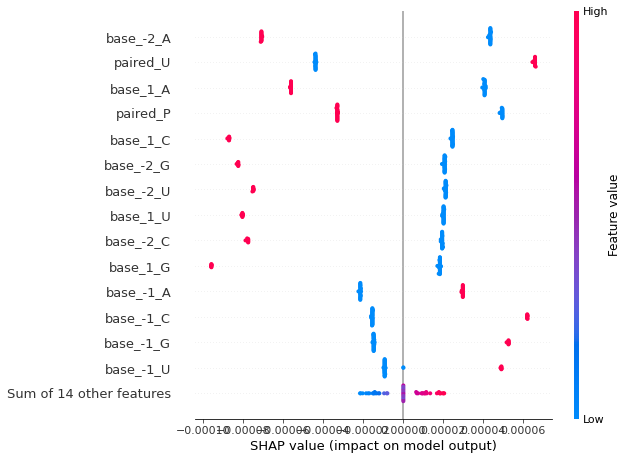

In [59]:
# 2A3
shap.plots.beeswarm(shap_values[:, :, 0], max_display=15)

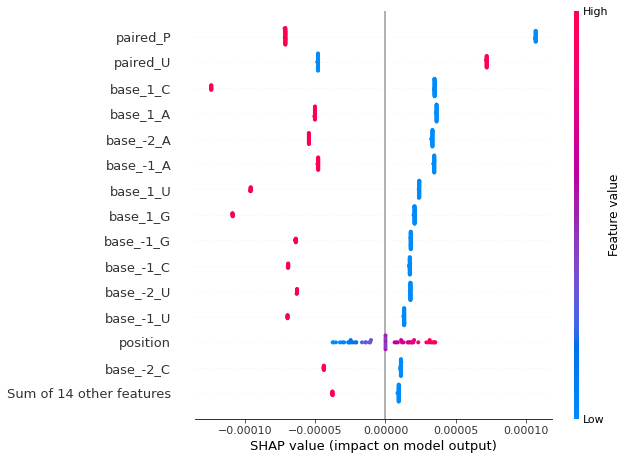

In [60]:
# DMS
shap.plots.beeswarm(shap_values[:, :, 1], max_display=15)

In [25]:
# merge shap values for dummy encoded categories of a particular category
# code adapted from https://medium.com/p/7c63e6a554ea

n_categories = [1, 4, 5, 5, 5, 5, 3]
# in order: base identity, neighbors, position, then Vienna predictions

new_shap_values = []
for values in shap_values.values:
    #split shap values into a list for each feature
    values_split = np.split(values, np.cumsum(n_categories))[:-1]
    # [:-1] to get rid of empty array at the end that results for reasons I don't entirely understand
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    new_shap_values.append(values_sum)

#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data 
new_data = np.array(df_test.drop(['2A3_react', 'DMS_react'], axis = 1))
shap_values.data = np.array(new_data)

#update feature names
feature_names = ['position', 'base', 'base_-2', 'base_-1', 'base_1', 'base_2', 'paired']
shap_values.feature_names = feature_names

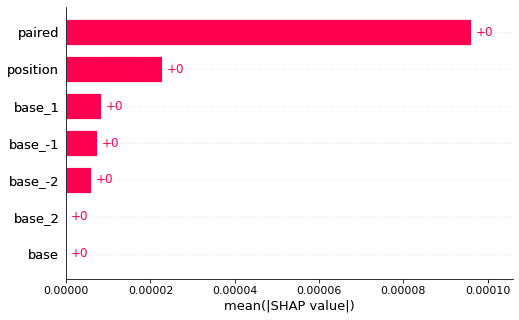

In [26]:
# Mean SHAP for 2A3
shap.plots.bar(shap_values[:, :, 0])

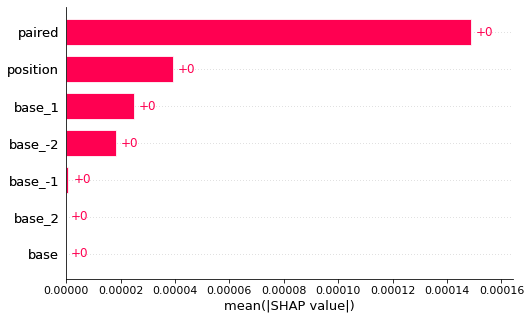

In [27]:
# Mean SHAP for DMS
shap.plots.bar(shap_values[:, :, 1])

While the SHAP values are not as meaningful or interpretable as they would be with fewer categorical variables, we can still get some idea of which components are playing the biggest role. For both probes, neighbor nucleotide identity makes a difference, although being towards either end of the sequence doesn't seem to play a big role.

From the grouped property bar plots, it appears that for backbone flexibility nearer neighbors make more of a difference than further neighbors, while for base-pairing surface reactivity, the identity of the immediate 3' neighbor and the base one over in the 5' direction make the biggest difference. No scientific rationale immediately comes to mind, thus this is likely to be an artifact or represent some other underlying property. 

No matter how we look at it, all the SHAP values seem very small, and the model is clearly relying heavily on the Vienna predictions and then tweaking those slightly.